In [67]:
import tensorflow as tf
# from tensorflow import keras
import nltk
import simplemma
import pandas as pd
import pathlib
import json
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [68]:
working_dir = pathlib.Path.cwd()

nltk.download("stopwords")

# get Turkish stopwords
turkish_stopwords = nltk.corpus.stopwords.words("turkish")

# tokenizer without comma
regexp_tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")

# word corrections
with open(working_dir.parent / "data" / "input" / "word_corrections.json", "r") as file:
    word_corrections = json.load(file)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gokasci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1. Emergency
2. Normal
3. Non Emergency [Doctor]
4. Non Emergency [No Doctor]

In [69]:
clean_annotations = pd.read_csv(working_dir.parent / "data" / "output" / "clean_annotations.csv")

sentences = clean_annotations["relevant_text"].to_list()
labels = clean_annotations["classifications"].to_list()

In [70]:
sentences[:5]

['Kontrastsız Beyin BT Kafa kaidesi ve kalvarial kemik yapılar normal sınırlardadır. 4.ventrikül ve bazal sisternalar normal genişliktedir. Posterior fossa oluşumları olağandır. İntrakranial hipo veya hiperdens sınırlanabilen patoloji saptanmadı. 3.ventrikül orta hatta ve normal genişliktedir. Lateral ventriküller olağandır. Beyin orta hat yapılarında yer değiştirme saptanmamıştır. Serebral sulkuslar olağandır. Nazal septum sola deviye görünümdedir ve BTye yansıyan tipik bir akut iskemi bulgusu mevcut değildir.  Ancak bu konuda klinik kuşku varsa olgunun diffüzyon MRG ile değerlendirilmesi ve detaylandırılması daha yararlı olacaktır. ',
 'Sol serebellar hemisferde sekel ??? ensefalomalazi sahaları ve eski iskemi sekeli değişiklikler izlenmektedir. Sağ serebellar hemisfer düzeyinde de benzer bulgular izlenmekle birlikte her iki serebellumda atrofi bulguları ve folyolarda belirginleşme mevcuttur. Supratentorial kesitlerin değerlendirilmesinde 3. ve lateral ventrikul, konveksite sulkuslar

In [71]:
vocab_size = 10000
embedding_dim = 16
max_input_length = 25 # default
trunc_type='post'
padding_type='post'
oov_token = None # "<OOV>"
training_percent = 80

In [72]:
def find_and_replace_in_string(input_string, replacements):
    for key, value in replacements.items():
        input_string = input_string.replace(key, value)
    return input_string


def find_longest_sentence_length(sentences):
    longest_length = max(len(sentence.split()) for sentence in sentences)
    return longest_length


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_" + string])
    plt.show()


def sentence_cleaning_pipeline(sentences):
    return [
        find_and_replace_in_string(
            " ".join(
                [
                    simplemma.lemmatize(word, lang="tr").lower()
                    for word in regexp_tokenizer.tokenize(sentence)
                    if word not in turkish_stopwords
                ]
            ),
            word_corrections,
        )
        for sentence in sentences
    ]

1. Remove punctuation
2. Only lower letters
3. Lemmatize
4. Remove stop words
5. Manual corrections

In [73]:
clean_sentences = sentence_cleaning_pipeline(sentences)

# show clean sentences
clean_sentences[:5]

['kontrast beyin bt kafa kaide kalvarial kemik yapı normal sınır 4 ventrikül bazal sisternalar normal genişlik poster fos oluşum olağan i̇ntrakranial hipo hiperdens sınırlanabi patoloji sapta 3 ventrikül orta hatta normal genişlik lateral ventrikül olağan beyin orta hat yapı yer değiş sapta serebral sulkus olağan nazal septum sol deviye görünüm btye yansı tipik bir akut iskemi bulgu mevcut değil ancak konu klinik kuşku var olgu diffüzyon mrg değer detaylandırılması yarar ol',
 'sol serebellar hemisfer sekel ensefalomalazi saha eski iskemi sekel değişik izle sağ serebellar hemisfer düzey benzer bulgu izle birlikte iki serebellumda atrofi bulgu folyo belirgin mevcut supratentorial kesit değerlendirilmesin 3 lateral ventrikul konveksit sulkus atrofiye sekonder belirgin sağ poster serebral arter sula saha kronik iskemik sekel gliozis saha varlık mevcut periventrikuler lökoriazis alan izle',
 'periventriküler derin beyaz cevher kronik iskemik gliozise bağ dansite kayıp izle bazal sisterna s

In [74]:
labels[:5]

[1, 3, 3, 0, 0]

In [75]:
max_input_length = find_longest_sentence_length(clean_sentences)

In [76]:
# manuall test the word lemmatizer
# word = "hemisferde"
# simplemma.lemmatize(word, lang="tr").lower()

In [77]:
training_size = int(len(clean_sentences) * training_percent / 100)
training_sentences = clean_sentences[0:training_size]
testing_sentences = clean_sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [78]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_input_length, padding=padding_type, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_input_length, padding=padding_type, truncating=trunc_type)

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [79]:
testing_labels

array([3, 3, 2, 2, 3, 2, 3, 2, 3, 3, 3])

In [80]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_input_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [81]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 71, 16)            160000    
                                                                 
 global_average_pooling1d_2  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_10 (Dense)            (None, 64)                1088      
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                      

In [82]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/100


2/2 - 0s - loss: 1.3835 - accuracy: 0.4048 - val_loss: 1.3672 - val_accuracy: 0.6364 - 311ms/epoch - 155ms/step
Epoch 2/100
2/2 - 0s - loss: 1.3759 - accuracy: 0.4048 - val_loss: 1.3552 - val_accuracy: 0.6364 - 17ms/epoch - 8ms/step
Epoch 3/100
2/2 - 0s - loss: 1.3684 - accuracy: 0.4048 - val_loss: 1.3427 - val_accuracy: 0.6364 - 17ms/epoch - 9ms/step
Epoch 4/100
2/2 - 0s - loss: 1.3586 - accuracy: 0.4048 - val_loss: 1.3292 - val_accuracy: 0.6364 - 17ms/epoch - 8ms/step
Epoch 5/100
2/2 - 0s - loss: 1.3495 - accuracy: 0.4048 - val_loss: 1.3166 - val_accuracy: 0.6364 - 17ms/epoch - 9ms/step
Epoch 6/100
2/2 - 0s - loss: 1.3373 - accuracy: 0.4048 - val_loss: 1.3050 - val_accuracy: 0.6364 - 29ms/epoch - 15ms/step
Epoch 7/100
2/2 - 0s - loss: 1.3255 - accuracy: 0.4048 - val_loss: 1.2899 - val_accuracy: 0.6364 - 18ms/epoch - 9ms/step
Epoch 8/100
2/2 - 0s - loss: 1.3118 - accuracy: 0.4048 - val_loss: 1.2733 - val_accuracy: 0.6364 - 17ms/epoch - 8ms/step
Epoch 9/100
2/2 - 0s - loss: 1.2973 - ac

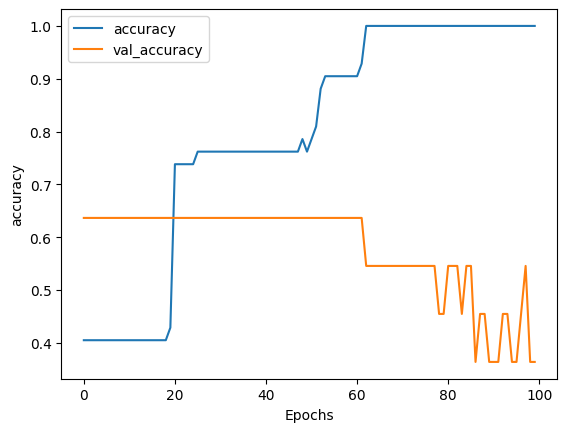

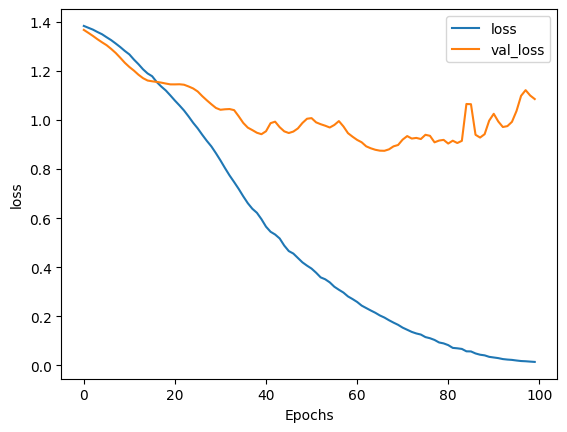

In [83]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [84]:
# reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# def decode_sentence(text):
#     return ' '.join([reverse_word_index.get(i, '?') for i in text])

# print(decode_sentence(training_padded[0]))
# print(training_sentences[2])
# print(labels[2])

In [85]:
# e = model.layers[0]
# weights = e.get_weights()[0]
# print(weights.shape) # shape: (vocab_size, embedding_dim)

In [86]:
testing_item = 10

In [87]:
sentence = clean_sentences[testing_item]
sentence

'kafa taban verteks ara el ol kesit kafa kaide kalvarial kemik yapı normal sınır 4 ventrikül bazal sisternalar normal genişlik poster fos oluşum olağan i̇ntrakranial hipo hiperdens sınırlanabi patoloji sapta 3 ventrikül orta hatta normal genişlik lateral ventrikül olağan beyin orta hat yapı yer değiş sapta serebral sulkus olağan'

In [88]:

sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(
    sequences, maxlen=max_input_length, padding=padding_type, truncating=trunc_type
)
predictions = model.predict(padded)
predictions

11/11 [==============================] - 0s 580us/step


array([[4.0323539e-03, 1.5294230e-08, 5.4858136e-01, 4.4738629e-01],
       [4.0323539e-03, 1.5294230e-08, 5.4858136e-01, 4.4738629e-01],
       [4.0323539e-03, 1.5294230e-08, 5.4858136e-01, 4.4738629e-01],
       ...,
       [4.0323539e-03, 1.5294230e-08, 5.4858136e-01, 4.4738629e-01],
       [4.0323539e-03, 1.5294230e-08, 5.4858136e-01, 4.4738629e-01],
       [4.0323539e-03, 1.5294230e-08, 5.4858136e-01, 4.4738629e-01]],
      dtype=float32)

In [89]:
labels[testing_item]

1

In [90]:
max_index = np.argmax(predictions[0])
max_index

2